# Visualize input space

## 1. Prepare dataset and denpendent files.
- `input_config.json`: This file controls how to generate input data.
- `MTMC_precursors.csv`: This file contains properties of binary carbides.
- `MTMC_properties.CSV`: This is the equiatomic dataset.

## 2. Import input generator

In [1]:
from elasticnet import x_main
from elasticnet.lib import HecFeatureGenerator, HecFeatureParser

## 3. Generate chemical formulas with equal molar ratios

In [2]:
from itertools import combinations
import pymatgen
from pymatgen.core.ion import Ion
import numpy as np

def sort_formula(formula):
    if isinstance(formula, str):
        comp = Ion.from_formula(formula)
        elements = comp.elements
        ele_name = [x.name for x in elements]
    if isinstance(formula, (list, tuple)):
        ele_name = list(formula)
    ele_name.sort()
    comp_name = ''.join(ele_name)
    return comp_name

elements = ['Ti', 'Zr', 'Hf', 'V', 'Nb', 'Ta', 'Cr', 'Mo', 'W']
outputs = []
for number_of_components in [1,2,3,4,5]:
    tmp = list(combinations(elements, number_of_components))

outputs.extend([sort_formula(x) for x in tmp])

np.savetxt('formulas.txt', outputs, fmt='%s')

## 4. Generate chemical formulas with non-equal molar ratios

In [3]:
import numpy as np
from elasticnet.lib import get_number_of_components
num, formulas = [], []
for Ti_c in range(0, 11):
    end = 11 - Ti_c
    for V_c in range(0, end):
        end = 11 - Ti_c - V_c
        for Cr_c in range(0, end):
            end = 11 - Ti_c - V_c - Cr_c
            for Zr_c in range(0, end):
                end = 11 - Ti_c - V_c - Cr_c - Zr_c
                for Nb_c in range(0, end):
                    end = 11 - Ti_c - V_c - Cr_c - Zr_c - Nb_c
                    for Mo_c in range(0, end):
                        end = 11 - Ti_c - V_c - Cr_c - Zr_c - Nb_c - Mo_c
                        for Hf_c in range(0, end):
                            end = 11 - Ti_c - V_c - Cr_c - Zr_c - Nb_c - Mo_c - Hf_c
                            for Ta_c in range(0, end):
                                W_c = 11 - Ti_c - V_c - Cr_c - Zr_c - Nb_c - Mo_c - Hf_c - Ta_c
                                formula = f'Ti{Ti_c}V{V_c}Cr{Cr_c}Zr{Zr_c}Nb{Nb_c}Mo{Mo_c}Hf{Hf_c}Ta{Ta_c}W{W_c}C11'
                                n_comp, real_formula = get_number_of_components(formula)
                                formulas.append(real_formula)

formulas = [x for x in formulas if x != '']
num = [x for x in num if x != 0]
np.savetxt('non-equiatomic_formulas.txt', formulas, fmt='%s')

print(formulas[100:200])

['Mo1Hf4W6C11', 'Mo1Hf4Ta1W5C11', 'Mo1Hf4Ta2W4C11', 'Mo1Hf4Ta3W3C11', 'Mo1Hf4Ta4W2C11', 'Mo1Hf4Ta5W1C11', 'Mo1Hf5W5C11', 'Mo1Hf5Ta1W4C11', 'Mo1Hf5Ta2W3C11', 'Mo1Hf5Ta3W2C11', 'Mo1Hf5Ta4W1C11', 'Mo1Hf6W4C11', 'Mo1Hf6Ta1W3C11', 'Mo1Hf6Ta2W2C11', 'Mo1Hf6Ta3W1C11', 'Mo1Hf7W3C11', 'Mo1Hf7Ta1W2C11', 'Mo1Hf7Ta2W1C11', 'Mo1Hf8W2C11', 'Mo1Hf8Ta1W1C11', 'Mo1Hf9W1C11', 'Mo2W9C11', 'Mo2Ta1W8C11', 'Mo2Ta2W7C11', 'Mo2Ta3W6C11', 'Mo2Ta4W5C11', 'Mo2Ta5W4C11', 'Mo2Ta6W3C11', 'Mo2Ta7W2C11', 'Mo2Ta8W1C11', 'Mo2Hf1W8C11', 'Mo2Hf1Ta1W7C11', 'Mo2Hf1Ta2W6C11', 'Mo2Hf1Ta3W5C11', 'Mo2Hf1Ta4W4C11', 'Mo2Hf1Ta5W3C11', 'Mo2Hf1Ta6W2C11', 'Mo2Hf1Ta7W1C11', 'Mo2Hf2W7C11', 'Mo2Hf2Ta1W6C11', 'Mo2Hf2Ta2W5C11', 'Mo2Hf2Ta3W4C11', 'Mo2Hf2Ta4W3C11', 'Mo2Hf2Ta5W2C11', 'Mo2Hf2Ta6W1C11', 'Mo2Hf3W6C11', 'Mo2Hf3Ta1W5C11', 'Mo2Hf3Ta2W4C11', 'Mo2Hf3Ta3W3C11', 'Mo2Hf3Ta4W2C11', 'Mo2Hf3Ta5W1C11', 'Mo2Hf4W5C11', 'Mo2Hf4Ta1W4C11', 'Mo2Hf4Ta2W3C11', 'Mo2Hf4Ta3W2C11', 'Mo2Hf4Ta4W1C11', 'Mo2Hf5W4C11', 'Mo2Hf5Ta1W3C11', 'Mo2Hf5Ta2W2C11', 

## 5. Generate inputs

In [4]:
import json
import numpy as np
import os

with open('input_config.json', 'r') as f:
    config = json.load(f)

hfg = HecFeatureGenerator(prop_precursor_path=config['prop_precursor_path'],
                          props = config['props'],
                          operators=config['operators'])

# get x_data.txt
eq_formulas = np.loadtxt('formulas.txt', dtype=str)
non_eq_formulas = np.loadtxt('non-equiatomic_formulas.txt', dtype=str)
formulas = np.hstack((eq_formulas, non_eq_formulas))

features = hfg.get_input_feature_from_formula(*formulas)
np.savetxt('x_data_init.txt',features, fmt='%.16f')

hfp = HecFeatureParser('x_data_init.txt')
new_features = hfp.reduce_dimension_by_PCA(n_components=2,
                                save_model=False,
                                load_model=False,
                                model_path=os.path.join('.'),
                                save_file=True)

eq_features_pca = new_features[0:len(eq_formulas)]
non_eq_features_pca = new_features[len(eq_formulas):]
print(np.shape(eq_features_pca), np.shape(non_eq_features_pca))

[0.6164282  0.49452145]
[0.28440733 0.22816206]
0.512569390245406
[164.47102639 147.31288   ]
Input shape after PCA: (43884, 2)
(126, 2) (43758, 2)


## 6. Visualize

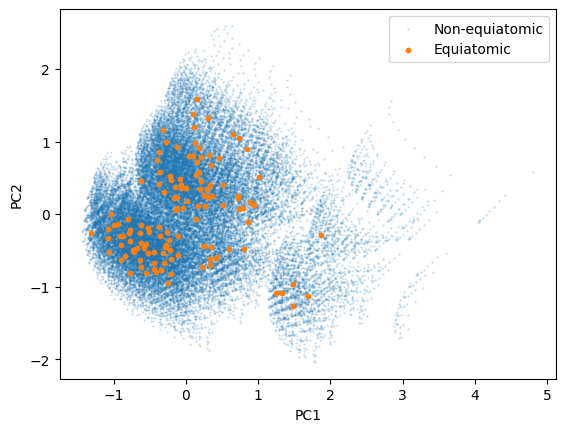

In [5]:
import matplotlib.pyplot as plt

plt.scatter(non_eq_features_pca[:,0],non_eq_features_pca[:,1], s=0.2, alpha=0.3, label='Non-equiatomic')
plt.scatter(eq_features_pca[:,0],eq_features_pca[:,1], s=10, label='Equiatomic')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## 7. Three principal components

[0.6164282  0.49452145 0.31096266]
[0.28440733 0.22816206 0.1434718 ]
0.6560411881301713
[164.47102639 147.31288    116.81598578]
Input shape after PCA: (43884, 3)


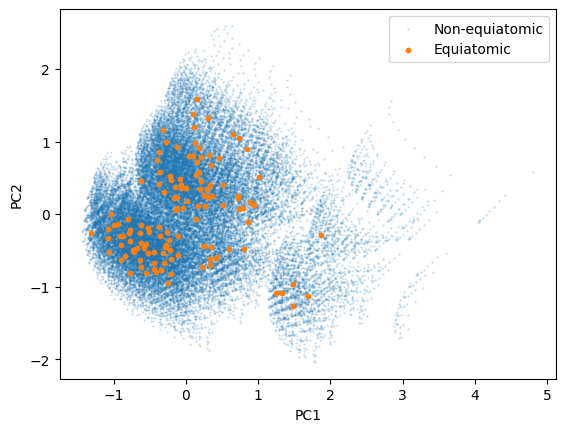

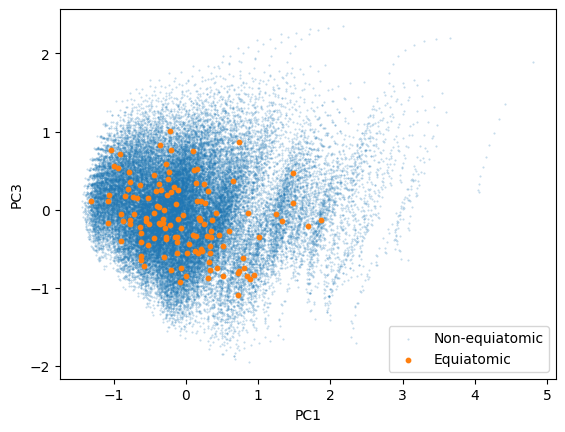

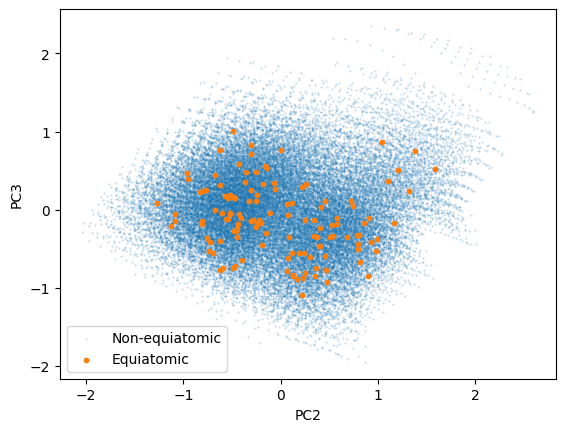

In [6]:
hfp = HecFeatureParser('x_data_init.txt')
features_3PC = hfp.reduce_dimension_by_PCA(n_components=3,
                                save_model=False,
                                load_model=False,
                                model_path=os.path.join('.'),
                                save_file=False)
eq_features_pca_3pc = features_3PC[0:len(eq_formulas)]
non_eq_features_pca_3pc = features_3PC[len(eq_formulas):]

plt.scatter(non_eq_features_pca_3pc[:,0],non_eq_features_pca_3pc[:,1], s=0.2, alpha=0.3, label='Non-equiatomic')
plt.scatter(eq_features_pca_3pc[:,0],eq_features_pca_3pc[:,1], s=10, label='Equiatomic')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

plt.scatter(non_eq_features_pca_3pc[:,0],non_eq_features_pca_3pc[:,2], s=0.2, alpha=0.3, label='Non-equiatomic')
plt.scatter(eq_features_pca_3pc[:,0],eq_features_pca_3pc[:,2], s=10, label='Equiatomic')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.legend()
plt.show()

plt.scatter(non_eq_features_pca_3pc[:,1],non_eq_features_pca_3pc[:,2], s=0.2, alpha=0.3, label='Non-equiatomic')
plt.scatter(eq_features_pca_3pc[:,1],eq_features_pca_3pc[:,2], s=10, label='Equiatomic')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend()
plt.show()